<a href="https://colab.research.google.com/github/gulabpatel/YOLOs/blob/main/Supervision/02_Supervision_Detectron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Supervision and Ultralytics (Yolo V8)

In [1]:
!pip install -U supervision ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 5.2 MB/s eta 0:00:00


set home var

In [2]:
import numpy as np
import os
HOME = os.getcwd()
print(HOME)

/content


download subway video

In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz" -O subway.mp4 && rm -rf /tmp/cookies.txt

In [5]:
SUBWAY_VIDEO_PATH = f"{HOME}/subway.mp4"

#Get Image with label using YoloV8 + Supervision

100%|██████████| 6.23M/6.23M [00:00<00:00, 128MB/s]



WARNING ⚠️ NMS time limit 0.550s exceeded
0: 1280x736 12 persons, 1 backpack, 2 handbags, 1 teddy bear, 108.2ms
Speed: 24.7ms preprocess, 108.2ms inference, 649.5ms postprocess per image at shape (1, 3, 1280, 736)


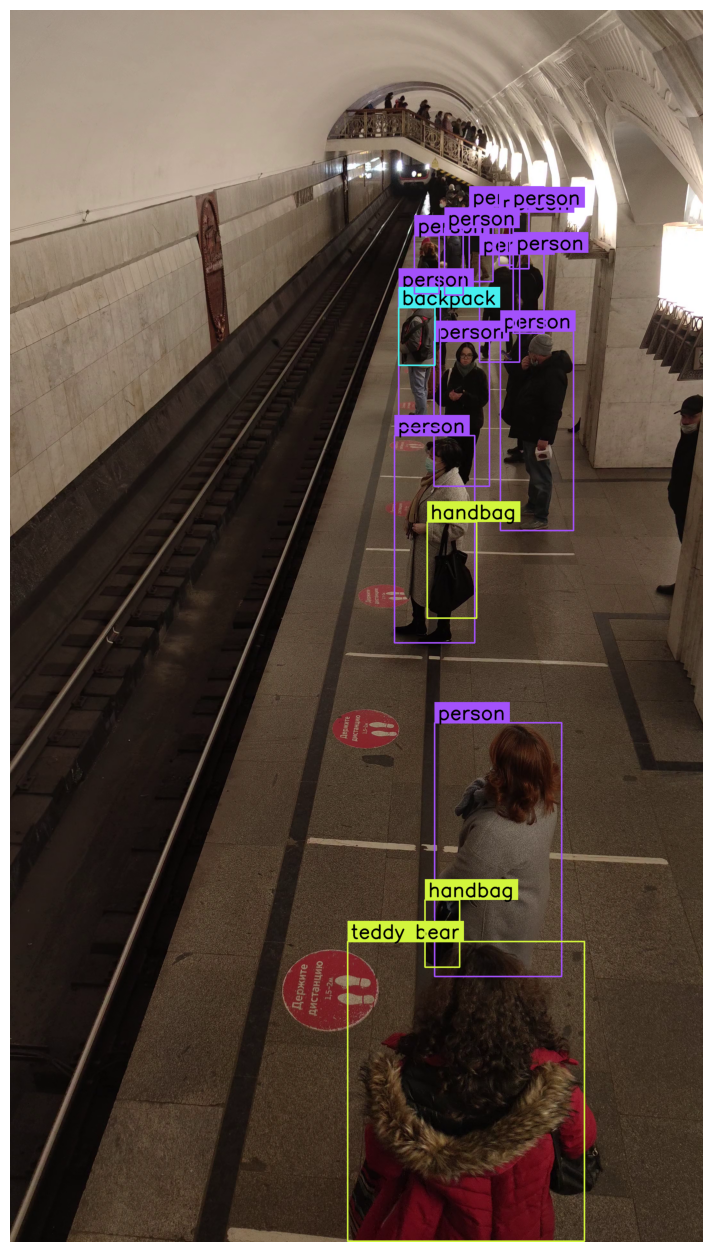

In [6]:
import supervision as sv
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

# extract video frame
generator = sv.get_video_frames_generator(SUBWAY_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)
label_annotator = sv.LabelAnnotator()


labels = [
    results.names[class_id]
    for class_id
    in detections.class_id
]

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
box_annotator = box_annotator.annotate( scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(frame, (16, 16))

#Get Detectron 2

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [8]:
from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

detectron2: 0.6


In [9]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:02, 88.6MB/s]                          


In [10]:
from detectron2.data import MetadataCatalog

# extract video frame
generator = sv.get_video_frames_generator(SUBWAY_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'handbag', 'backpack', 'handbag', 'person', 'stop sign', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


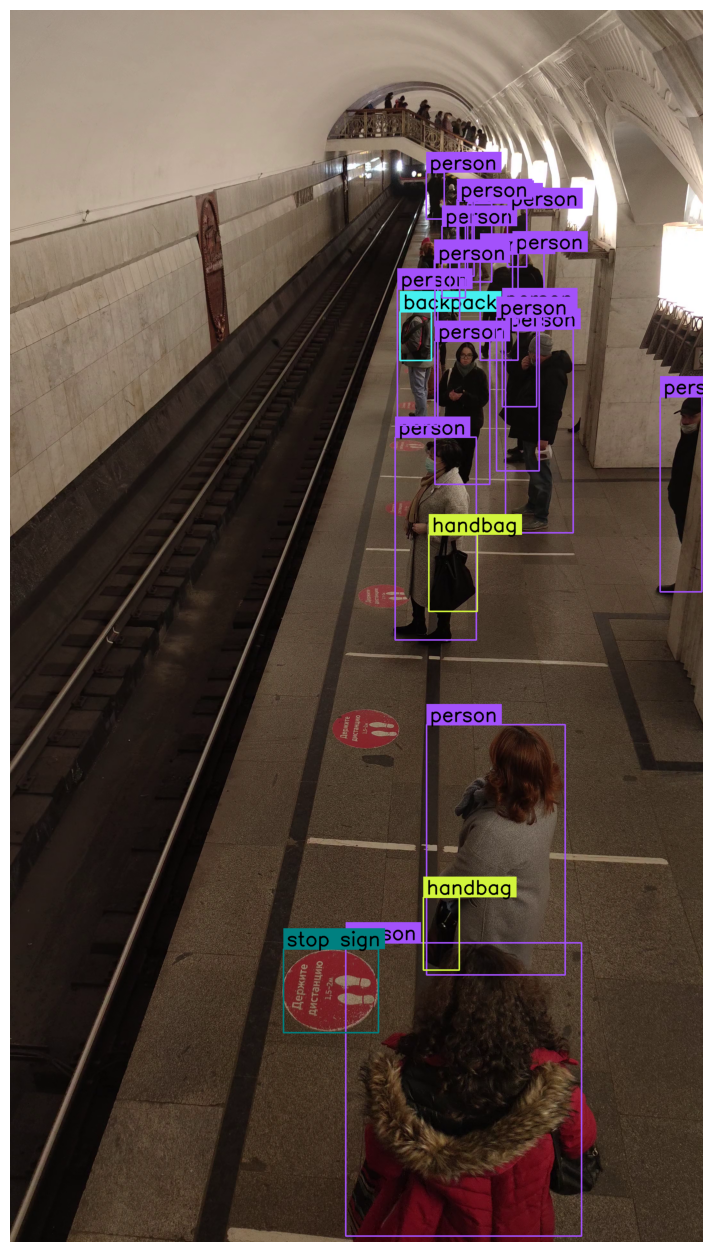

In [11]:
outputs = predictor(frame) #using detectron
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)


#get the labels form detectron
pred_classes = outputs['instances'].pred_classes.cpu().tolist() #list fo class id
class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes #get our dataset
pred_class_names = list(map(lambda x: class_names[x], pred_classes)) #get the names
print(pred_class_names)


# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=detections,labels=pred_class_names)



%matplotlib inline
sv.plot_image(frame, (16, 16))

In [12]:
sv.VideoInfo.from_video_path(SUBWAY_VIDEO_PATH)

VideoInfo(width=2160, height=3840, fps=29, total_frames=1298)

#polygone on image and tracking

In [13]:
# initiate polygon zone
polygon = np.array([
    [200, 3840],
    [1300, 600],
    [1325, 600],
    [550, 3840]
])
video_info = sv.VideoInfo.from_video_path(SUBWAY_VIDEO_PATH)
zone = sv.PolygonZone(
    polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(
    zone=zone, color=sv.Color.red(), thickness=10, text_thickness=10, text_scale=4)

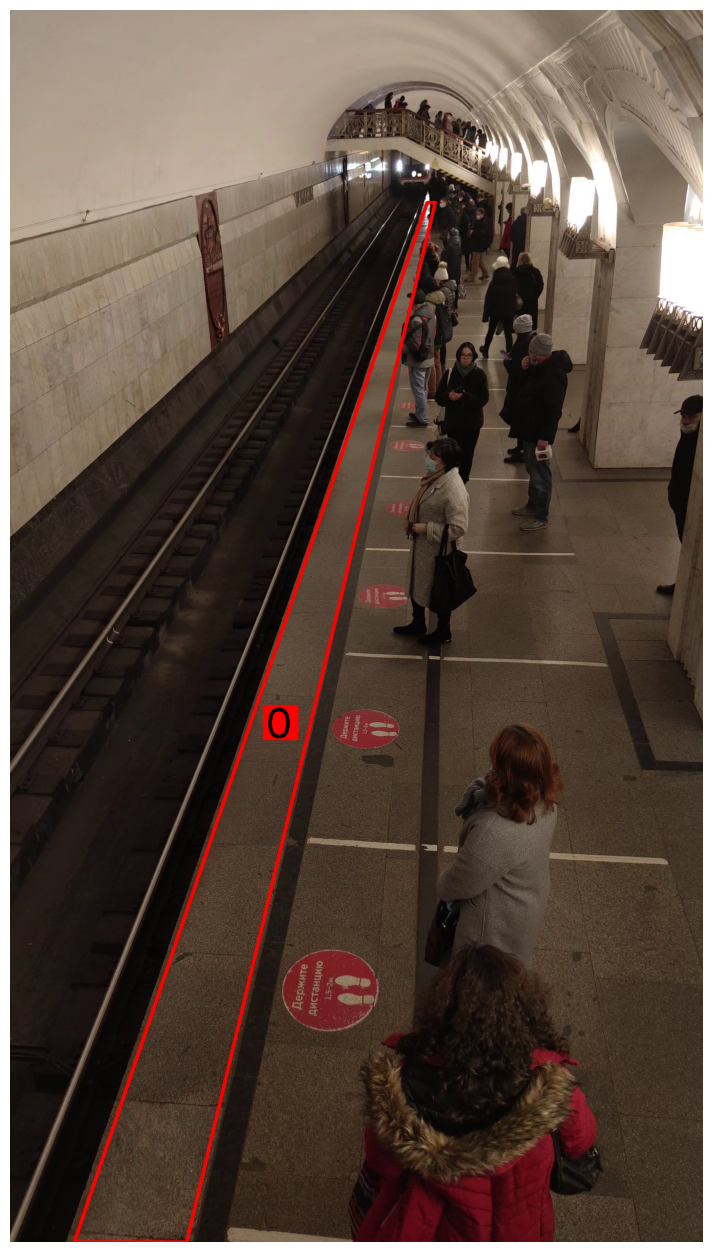

In [18]:
# extract video frame
generator = sv.get_video_frames_generator(SUBWAY_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
outputs = predictor(frame)
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
box_mask_annotator = sv.MaskAnnotator(color=sv.Color.from_hex("#FFA500"))
frame = box_mask_annotator.annotate(scene=frame, detections=detections)
#box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2,color=sv.Color.from_hex("#FFA500"))
#frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)

frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(frame, (16, 16))

#Video Tracking with polygon

In [19]:
from IPython import display
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [200, 3840],
    [1300, 600],
    [1325, 600],
    [550, 3840]
])
video_info = sv.VideoInfo.from_video_path(SUBWAY_VIDEO_PATH)
zone = sv.PolygonZone(
    polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(
    zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)


def process_frame(frame: np.ndarray, i: int) -> np.ndarray:
    print('frame', i)
    # detect
    outputs = predictor(frame)
    detections = sv.Detections(
        xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
        confidence=outputs["instances"].scores.cpu().numpy(),
        class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
    )
    detections = detections[detections.class_id == 0]
    zone.trigger(detections=detections)

    # annotate
    box_annotator = sv.BoxAnnotator(
        thickness=4, text_thickness=4, text_scale=2)
    frame = box_annotator.annotate(
        scene=frame, detections=detections, skip_label=True)
    frame = zone_annotator.annotate(scene=frame)

    return frame


sv.process_video(source_path=SUBWAY_VIDEO_PATH,
                 target_path=f"{HOME}/subway-result.mp4", callback=process_frame)

display.clear_output()